In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.models import Model
from keras.layers import *
from keras.activations import *

In [0]:
def get_gru_last_step(lstm_sequences):
    return Lambda(lambda sequence: sequence[:, -1, :])(lstm_sequences)

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

gru_options = {
    'units': 32,
    'dropout': 0.2,
    'return_sequences': True
}

In [11]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(averaged_embedding_layer)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features_1 = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(gru)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features_2 = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

pooled_features = concatenate([pooled_features_1, pooled_features_2])
pooled_features = Dropout(0.2)(pooled_features)

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21408/102124 [=====>........................] - ETA: 6:50 - loss: 0.1175 - acc: 0.9606

102112/102124 [============================>.] - ETA: 0s - loss: 0.0733 - acc: 0.9744

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0733 - acc: 0.9744 - val_loss: 0.0470 - val_acc: 0.9832
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 7:08 - loss: 0.0558 - acc: 0.9795

102112/102124 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9804

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0530 - acc: 0.9804 - val_loss: 0.0456 - val_acc: 0.9829
roc-auc: 0.9863 - roc-auc_val: 0.9835                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 7:35 - loss: 0.0516 - acc: 0.9809

102112/102124 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9815

102124/102124 [==============================] - 553s 5ms/step - loss: 0.0488 - acc: 0.9815 - val_loss: 0.0477 - val_acc: 0.9826
Epoch 4/32
 10176/102124 [=>............................] - ETA: 7:28 - loss: 0.0466 - acc: 0.9821

102112/102124 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9822

102124/102124 [==============================] - 554s 5ms/step - loss: 0.0466 - acc: 0.9822 - val_loss: 0.0443 - val_acc: 0.9832
roc-auc: 0.9896 - roc-auc_val: 0.9866                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 7:36 - loss: 0.0471 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9829

102124/102124 [==============================] - 560s 5ms/step - loss: 0.0452 - acc: 0.9829 - val_loss: 0.0510 - val_acc: 0.9817
Epoch 6/32
 10176/102124 [=>............................] - ETA: 7:32 - loss: 0.0413 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9831

102124/102124 [==============================] - 560s 5ms/step - loss: 0.0437 - acc: 0.9831 - val_loss: 0.0414 - val_acc: 0.9842
roc-auc: 0.9909 - roc-auc_val: 0.9873                                                                                                    
Epoch 7/32
  8736/102124 [=>............................] - ETA: 7:34 - loss: 0.0439 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9833

102124/102124 [==============================] - 558s 5ms/step - loss: 0.0429 - acc: 0.9833 - val_loss: 0.0437 - val_acc: 0.9837
Epoch 8/32
 10176/102124 [=>............................] - ETA: 7:28 - loss: 0.0411 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9836

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0419 - acc: 0.9836 - val_loss: 0.0450 - val_acc: 0.9834

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00024148408556357026.
roc-auc: 0.9919 - roc-auc_val: 0.9884                                                                                                    
Epoch 9/32
  5952/102124 [>.............................] - ETA: 7:55 - loss: 0.0408 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9839

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0412 - acc: 0.9839 - val_loss: 0.0430 - val_acc: 0.9841
Epoch 10/32
 10144/102124 [=>............................] - ETA: 7:36 - loss: 0.0393 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9841

102124/102124 [==============================] - 562s 6ms/step - loss: 0.0405 - acc: 0.9841 - val_loss: 0.0427 - val_acc: 0.9839
roc-auc: 0.9926 - roc-auc_val: 0.9888                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 7:39 - loss: 0.0404 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9842

102124/102124 [==============================] - 562s 6ms/step - loss: 0.0400 - acc: 0.9842 - val_loss: 0.0456 - val_acc: 0.9833
Epoch 12/32
 10144/102124 [=>............................] - ETA: 7:35 - loss: 0.0403 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9843

102124/102124 [==============================] - 560s 5ms/step - loss: 0.0397 - acc: 0.9843 - val_loss: 0.0457 - val_acc: 0.9834
roc-auc: 0.993 - roc-auc_val: 0.9887                                                                                                    
Epoch 13/32
  8736/102124 [=>............................] - ETA: 7:44 - loss: 0.0396 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9845

102124/102124 [==============================] - 560s 5ms/step - loss: 0.0394 - acc: 0.9845 - val_loss: 0.0432 - val_acc: 0.9838
Epoch 14/32
 10144/102124 [=>............................] - ETA: 7:26 - loss: 0.0361 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9846

102124/102124 [==============================] - 559s 5ms/step - loss: 0.0388 - acc: 0.9846 - val_loss: 0.0446 - val_acc: 0.9836
roc-auc: 0.9933 - roc-auc_val: 0.9886                                                                                                    
Epoch 15/32
  8704/102124 [=>............................] - ETA: 7:39 - loss: 0.0368 - acc: 0.9851

102112/102124 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9847

102124/102124 [==============================] - 555s 5ms/step - loss: 0.0386 - acc: 0.9847 - val_loss: 0.0434 - val_acc: 0.9844
Epoch 16/32
 10144/102124 [=>............................] - ETA: 7:25 - loss: 0.0379 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9851

102124/102124 [==============================] - 552s 5ms/step - loss: 0.0379 - acc: 0.9851 - val_loss: 0.0430 - val_acc: 0.9843
roc-auc: 0.9936 - roc-auc_val: 0.9884                                                                                                    


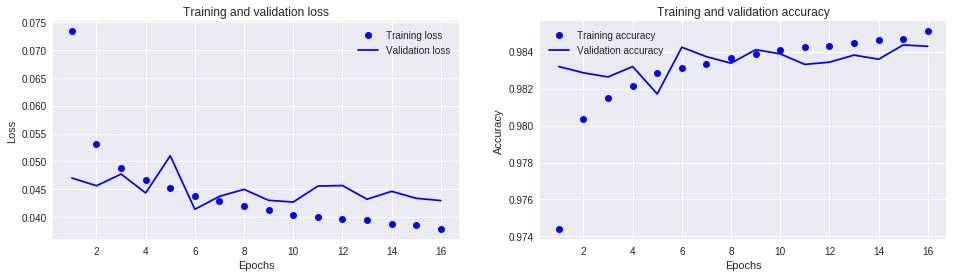

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 76s 2ms/step
([0.04146074880179781, 0.9846623722315021], 0.9902276439975358)
